In this notebook, we'll be doing flower- IRIS classification. This dataset purely is numerical & we'll be exclusively using tensorflow 2.x's newest dataset api (tfds) which is a wrapper around tf.data api. Though it has a bit of a learning curve (as opposed to using keras' functional api + fit method), we'll still try explore it for its clear advantage in execution speed. Furthermore, we'll be using tf 2.x's eager execution feature in the model training itself so as to get the gradient descent out of the black box & to get finer control over the training.

In [0]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, regularizers, models
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

Once the required libraries are loaded, we can import the iris dataset.
Iris is an single-label numerical classification dataset with 3 classes.


In [161]:
ds, info = tfds.load("iris", split=tfds.Split.TRAIN, with_info = True)
print(info)

tfds.core.DatasetInfo(
    name='iris',
    version=2.0.0,
    description='This is perhaps the best known database to be found in the pattern recognition
literature. Fisher's paper is a classic in the field and is referenced
frequently to this day. (See Duda & Hart, for example.) The data set contains
3 classes of 50 instances each, where each class refers to a type of iris
plant. One class is linearly separable from the other 2; the latter are NOT
linearly separable from each other.
',
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=150,
    splits={
        'train': 150,
    },
    supervised_keys=('features', 'label'),
    citation="""@misc{Dua:2019 ,
    author = "Dua, Dheeru and Graff, Casey",
    year = "2017",
    title = "{UCI} Machine Learning Repository",
    url = "http://archi

As per above information, there are 150 samples where each sample has 4 features & labels with 3 classes. Now apperently there is no VALIDATION & TEST split available for this dataset in TFDS. so we have to split the training split itself (In TFDS parts of the dataset are called SPLIT) into 2 set: Training & Test.

In [0]:
ds_train, info_train = tfds.load("iris", split='train[:80%]', with_info = True)
ds_val, info_val = tfds.load("iris", split='train[-20%:]', with_info = True)
#print(len(list(ds_train.as_numpy_iterator()))) to verfiy the count but shouldn't be used for larger dataset

unfortunately TF dataset does not have cleaner way to get total length of a split (dataset). Even seeing single sample is little hacky as shown below. 

In [163]:
sample = next(iter(ds_train.take(1)))
print(sample)

{'features': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([5.1, 3.4, 1.5, 0.2], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}


Now, ideally we would be normalizing the numerical features before training but in case of iris dataset, the standard deviation & mean values per column aren't so huge so we can trust the gradient descent to adjust the weights accordingly. Otherwise we would've used tensorflow transform (tft) library for data normalization.
Now, irrespective of whether or not we're doing any normalization, we need to write a preprocessing function to extract features & labels from the dataset records (dictionary)

In [0]:
def preprocessing_fn(inputs):
  print(a)
  features= inputs['features']
  label = inputs['label']#by referring above info object
  return features, label

Now, preprocssing function will be just the begining of the input pipeline. Next part of the pipeline will be shuffling & batching. So lets create the whole pipeline at once

In [165]:
ds_train, info_train = tfds.load("iris", split='train[:80%]', with_info = True)
ds_train = ds_train.map(preprocessing_fn).shuffle(1024).batch(32)
ds_val = ds_val.map(preprocessing_fn).batch(32)

The reason, i've re-initialized ds_train is because of some weird issue (not sure if it's an issue) in tfds. Apperantly if we use the take function once, we cannot map the dataset to a preprocessing function.

Later in the pipeline, shuffle function in takes buffer size as input & will shuffle the batches in runtime.(we can buffersize ignore it for now as it wont be critical for this dataset). Next we'll add a batching to pipeline so when we iterate over the dataset, we'll by default get data in batches

For the sake of performance improvement in larger datasets, you can use the prefetch() function in the pipeline (whcih asynchronously fetches the next batches when the model is busy with training) or you can wait for "snapshot" featues in tf 2.3 which would supposedly cache youe pre-processed data in local filesystem.

Now lets define the model itself

In [0]:
def model_fn():
  model_in = layers.Input((4,))
  a = layers.Dense(12, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(model_in)
  logits = layers.Dense(3)(a)
  model= models.Model(model_in, logits)
  return model

The model is fairly simple with just 1 hidden layer. If you've noticed, in the last layer i've not used softmax function despite this being a classification datset. This is because i need the raw logits this layer to calculate the loss manually. This wont affect our accuracy calculation as logits & probabilities max out at same location ( as-in argmax result for both would be same)

In [167]:
model = model_fn()
print(model.summary())

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_34 (Dense)             (None, 12)                60        
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 39        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________
None


Since we want to use eager execution, we have to write our own custom logic for trainig & validation using something called GradientTape. Now this tape is 2.x only feature meant to compute gardients on the fly. 

This way of doing training as opposed to simple model.fit may seem like an overkill for this dataset but getting familier with tf.data api & 
tapes could be perticularly useful when dealing with complex architectures like seq2seq, attention based models etc


So in order to use tape, we first need to define the optimizer & a loss function

In [0]:
optimizer = optimizers.RMSprop()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

After this we need a training function or more of training step function which will be responsible for forward & backward prop.

Also an evaluation function which will calcuate loss & logits for validation data

In [0]:
@tf.function
def train_step(batch_data, labels):
  #forward propagation
  with tf.GradientTape() as tape:
    logits = model(batch_data, training=True)
    loss_val = loss_object(labels, logits)
  #backpropagation
  gradients = tape.gradient(loss_val, model.trainable_variables)
  #based on backprop, update model weights
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  metric.update_state(labels, logits)
  return loss_val

@tf.function
def evaluation_step(batch_data):
  logits= model(batch_data, training=False)
  loss_val = loss_object(labels, logits)
  return logits, loss_val

Notice the @tf.function decorator on top of these functions, this tell tensorflow to create graph for this fucntions. This will improve the speed of training as we want a singleton execution for Forward & backward prop.
This decorator can be removed for the sake if you want to debug your model training. If you remove this decorator, you'll also get access to the numpy() values of the tensors like grads, batch_loss etc. Pretty inconvinient Eh ?

Also, the reason this training step is defined for the execution of 1 batch is because gradient tapes can only be used once. When instantiated, the record all the operations in forward prop & then these ops are used to calcualte gradients in backward propagation

Now, we can write the epoch & batch level training loop.

In [170]:
# tf.executing_eagerly()
metrics = {
    'loss':[],
    'acc':[],
    'val_loss':[],
    'val_acc':[]
}
for epoch in range(150):
  tf.print('Epoch ',epoch,' started')
  metric.reset_states()
  num_batches = 0
  epoch_loss_train = 0
  for batch_data, labels in ds_train:
    batch_loss = train_step(batch_data, labels)
    # batch_loss = batch_loss.numpy().mean()
    num_batches += 1
    epoch_loss_train += batch_loss
  epoch_loss_train /= num_batches
  epoch_acc_train = metric.result()
  #do the same for validation set
  metric.reset_states()
  for batch_data, labels in ds_val:
    logits, loss_val = evaluation_step(batch_data)
    metric.update_state(labels, logits)
  epoch_loss_val = loss_val #because we know there's one validation batch
  epoch_acc_val = metric.result()
  tf.print('Loss {0} | Acc {1} | Validation Loss {2} | Validation Acc {3}'.format(epoch_loss_train, epoch_acc_train, epoch_loss_val, epoch_acc_val))
  metrics['loss'].append(epoch_loss_train)
  metrics['val_loss'].append(epoch_acc_train)
  metrics['acc'].append(epoch_loss_val)
  metrics['val_acc'].append(epoch_acc_val)

  
  

Epoch  0  started
Loss 1.2170121669769287 | Acc 0.3333333432674408 | Validation Loss 1.1760237216949463 | Validation Acc 0.20000000298023224
Epoch  1  started
Loss 1.101813554763794 | Acc 0.23333333432674408 | Validation Loss 1.114747405052185 | Validation Acc 0.23333333432674408
Epoch  2  started
Loss 1.0629459619522095 | Acc 0.25 | Validation Loss 1.0737850666046143 | Validation Acc 0.20000000298023224
Epoch  3  started
Loss 1.025876760482788 | Acc 0.30000001192092896 | Validation Loss 1.0448575019836426 | Validation Acc 0.13333334028720856
Epoch  4  started
Loss 1.0010422468185425 | Acc 0.3583333194255829 | Validation Loss 1.0253793001174927 | Validation Acc 0.30000001192092896
Epoch  5  started
Loss 0.981864869594574 | Acc 0.3916666805744171 | Validation Loss 1.0062241554260254 | Validation Acc 0.3333333432674408
Epoch  6  started
Loss 0.9625654220581055 | Acc 0.40833333134651184 | Validation Loss 0.989669680595398 | Validation Acc 0.3333333432674408
Epoch  7  started
Loss 0.947477

After about 100 or so itertions, the val acc seems to be plateau. Of course these are not the most ideal hyperparametrs or the metrics, but for now they'll do the job.

We can plot the metrics to see how the training went

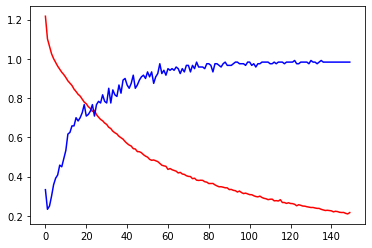

In [173]:
import matplotlib.pyplot as plt
plt.plot(metrics['loss'], c='r')
plt.plot(metrics['val_loss'], c='b')
plt.show()

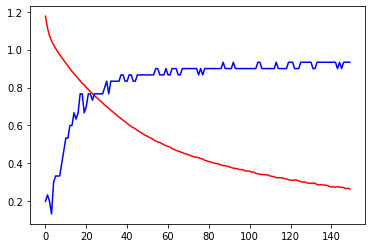

In [174]:
plt.plot(metrics['acc'], c='r')
plt.plot(metrics['val_acc'], c='b')
plt.show()

By the way, you can also use the tf dataset instance with all its pipeline components with keras' fit method also.

In [0]:
# def model_fn2():
#   model_in = layers.Input((4,))
#   a = layers.Dense(12, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(model_in)
#   logits = layers.Dense(3, activation='softmax')(a)
#   model= models.Model(model_in, logits)
#   return model

# model2 = model_fn2()
# model2.compile(optimizer='adam',loss='SparseCategoricalCrossentropy', metrics=['acc'])
# a = model2.fit(ds_train, epochs=100)